In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants
kB = 1

## IsingSolver class definition:

In [5]:
class IsingSolver:
    '''a class to store data and methods for an Ising model implementation'''
    
    def __init__(self, grid_type='square', dim=100, pbcs=True, J=[1], Jrule='nn', starting_temp=1):
        '''initialises a solution to the Ising Model'''
        
        self.grid_type=grid_type
        self.dim=dim
        self.pbcs=pbcs
        self.J=J
        self.Jrule ='nn'
        
        self.neighbours = []
        
                
        #create grid
        if self.grid_type == 'square':
            self.create_square_grid()
            
        
        #random initialisation of moments
        self.init_moments = np.random.choice([-1,1], self.X.shape )
        self.current_moments = np.copy(self.init_moments)    
        self.magnetisation =  self.current_moments.flatten().sum() 
        self.maglist = []
        self.maglist.append(self.magnetisation/ self.num_sites)
        
        self.energy_list = []
        self.current_energy = self.grid_energy(self.current_moments)
        self.energy_list.append(self.current_energy/ self.num_sites)
        self.temp = starting_temp
        
        if self.Jrule == 'nn':
            self.sums = np.array([-4, -2, 0, 2, 4, -3, -1, 1, 3])
            self.probs = np.exp(- 2 * J[0] *self.sums / (kB * self.temp) )
    
        
    def grid_energy(self, moments):
        '''calculates the TOTAL energy for the full grid. Usually only done once, at the start...'''
        energy=0.0
        if self.Jrule == 'nn':
            for i, mom in enumerate(moments):
                for neighbour in self.neighbours[i]:
                    if neighbour > i:
                        energy += (-self.J[0]) * mom * moments[neighbour] 
            
        return energy

        
    def single_update(self):
        '''update by cycling through every moment in the lattice once.'''
        
        newE = self.current_energy
        if self.Jrule == 'nn':
            for i, mom in enumerate(self.current_moments):
                neighsum = np.sum(mom*self.current_moments[self.neighbours[i]])
                deltaE = 2 *self.J[0] * neighsum
                deltaM = 0
                
                if(deltaE <= 0):
                    newE += deltaE
                    self.current_moments[i] = - self.current_moments[i]
                    deltaM = 2*self.current_moments[i]
                
                if(deltaE > 0):
                    prob = self.probs[np.where(self.sums == neighsum)]
                    if np.random.random() < prob :
                        newE += deltaE
                        self.current_moments[i] = - self.current_moments[i]
                        deltaM = 2*self.current_moments[i]
                
                self.magnetisation += deltaM
                    
        self.current_energy = newE
        self.energy_list.append(newE / self.num_sites)
        self.maglist.append(self.magnetisation/ self.num_sites)
        
        
    def run(self, num_its=100, temp=-1):
        '''Sweep through the lattice multiple times.
        Update the presaved probs array if a temperature is specified.'''
        if(temp != -1):
            self.temp = temp
            if self.Jrule == 'nn':
                self.probs = np.exp(- 2 * self.J[0] *self.sums / (kB * self.temp) )
                
        for it in range(num_its):
             self.single_update()
            
        
    def grid_figure(self, moments, figsize=(8,8)):
        '''Create a figure to show a particular configuration'''
        fig, ax=plt.subplots(figsize=figsize)
        ax.set_aspect('equal')
        ax.scatter(self.X, self.Y, c=moments, marker='o', s=2000*(figsize[0]/self.dim)**2)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_ylim(self.Y.min(), self.Y.max())
        ax.set_xlim(self.X.min(), self.X.max())
        return fig,ax
        
        
    def create_square_grid(self):
        '''Create a square grid of spins and the associated lists of neighbouring sites'''
        x, y = np.linspace(0, self.dim-1, self.dim), np.linspace(0, self.dim-1, self.dim)
        Y, X = np.meshgrid(y, x)
        self.X, self.Y = X.flatten(), Y.flatten()
        self.num_sites = self.dim * self.dim
        
        #list of neighbours for each site - different conditions with and without periodic boundaries
        for i, (x1, y1) in enumerate(zip(self.X, self.Y)):
       
            # if the lattice has periodic boundary conditions
            if self.pbcs == True:
                templist = [[ (x1-1) % self.dim , y1], [(x1+1)% self.dim , y1], [x1, (y1-1) % self.dim], [x1, (y1+1) % self.dim]]
                reallist = [int(a[0]*self.dim + a[1]) for a in templist ]
                self.neighbours.append(reallist)
                
            if self.pbcs == False:
                #if periodic boundary conditions are turned off
                templist = [[ (x1-1) , y1], [(x1+1) , y1], [x1, (y1-1) ], [x1, (y1+1) ]]
                tlist2=[]
                for element in templist:
                    if (element[0] >= 0) and (element[1] >= 0) and (element[0]< self.dim) and (element[1] < self.dim):
                        tlist2.append(element)
                reallist = [int(a[0]*self.dim + a[1]) for a in tlist2 ]
                self.neighbours.append(reallist)   
 

## Creating an instance of the solver:

Initial configuration:


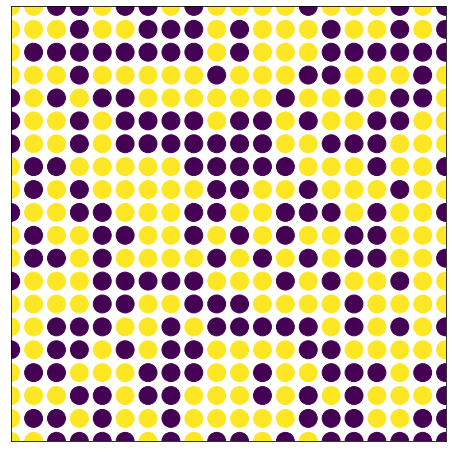

In [6]:
# create a solver, and plot the initial (random) state
solve = IsingSolver(J=[1], dim=20, pbcs=True, starting_temp=2)
print('Initial configuration:')
fig, ax = solve.grid_figure(solve.current_moments)
plt.show()


## Sweeping the lattice at a fixed temperature:

Final configuration:


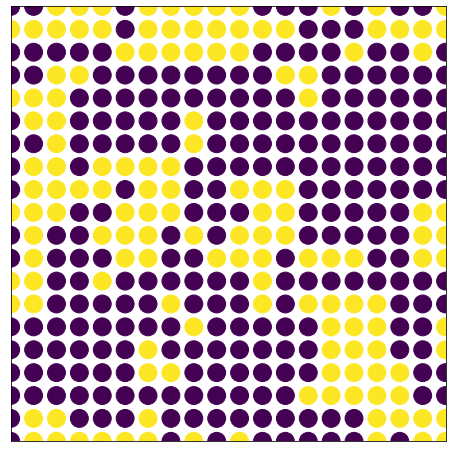

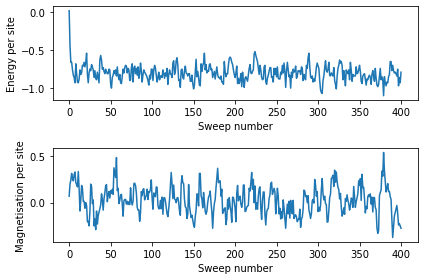

In [7]:
# run a certain number of sweeps at a certain temperature and plot the final state
solve.run(num_its = 400, temp=3)
print('Final configuration:')
fig, ax = solve.grid_figure(solve.current_moments)
plt.show()

# plot the evolution of energy and magnetisation per site
figa, axa = plt.subplots(2)
axa[0].plot(solve.energy_list)
axa[0].set_xlabel('Sweep number')
axa[0].set_ylabel('Energy per site')
axa[1].plot(solve.maglist)
axa[1].set_xlabel('Sweep number')
axa[1].set_ylabel('Magnetisation per site')
plt.tight_layout()
plt.show()

## Looping over temperature and plotting thermodynamic variables

In [8]:
templist = np.linspace(3, 1.6, 40)                # create a list of temperatures (decreasing order -- why?)

# lists to store average properties for each temperature
avgmag = np.zeros_like(templist)
aveng = np.zeros_like(templist)
avengsquared =np.zeros_like(templist)
stdeng=np.zeros_like(templist)
stdmag=np.zeros_like(templist)

# number of equilibriation and averaging sweeps for each temperature
testruns, countruns = 200, 200
def square(list):
    return [i ** 2 for i in list]
squarev=np.vectorize(square)
for i, temp in enumerate(templist):
    #warm up and run
    solve.run(num_its = testruns + countruns, temp=temp)
    aveng[i] = np.mean(solve.energy_list[-countruns:])
    avengsquared[i]=np.mean(square(solve.energy_list[-countruns:]))
    avgmag[i] = np.mean(np.abs(solve.maglist[-countruns:]))
    stdeng[i] = np.std(solve.energy_list[-countruns:])
    stdmag[i] = np.std(np.abs(solve.maglist[-countruns:]))


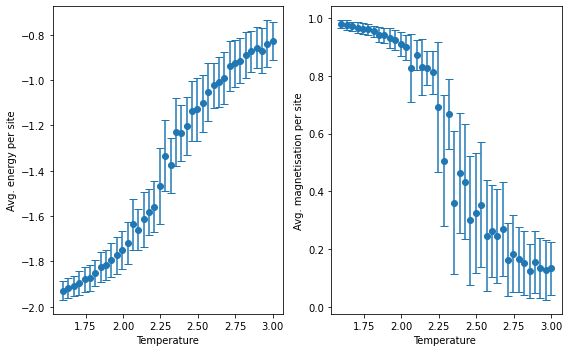

In [9]:
fig3 = plt.figure(figsize=(8, 5))
ax2 = fig3.add_subplot(121)
ax2.errorbar(templist, aveng, yerr=stdeng, fmt='o', capsize=4)
#ax2.plot(templist, aveng, '-')
ax2.set_xlabel('Temperature')
ax2.set_ylabel('Avg. energy per site')


ax3 = fig3.add_subplot(122)
ax3.errorbar(templist, abs(avgmag), yerr=stdmag, fmt='o', capsize=4)
#ax3.plot(templist, abs(avgmag), '-')
ax3.set_xlabel('Temperature ')
ax3.set_ylabel('Avg. magnetisation per site')

plt.tight_layout()
from scipy.optimize import leastsq
#import relevant library
plt.show()


1.0505180659688873 is the estimated value of c
2.2851323901710976 is the estimated value of Tc


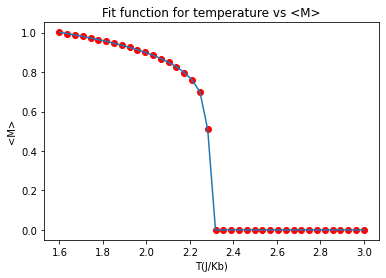

In [13]:
rev= list(reversed(avgmag))
#print(rev)
import scipy.optimize as optimization
from scipy.optimize import leastsq
def piecewise(T,c,Tc):
        if T< Tc:
            return c*((Tc-T)**(1/8))
        else:
            return 0
 #create a piecewise function for the variation of magnetisation with temperature       
        
piece=np.vectorize(piecewise)   
 #vectorize this to make it easier for plotting       
     
T= np.linspace(1.6,3,40) 
#array of temperatures
x0=0.3,1.7
#initial guesses for c and Tc 

fitparameter=optimization.curve_fit(piece,T,rev,x0 )[0]
#reversed the magnetisation data since it was originally organised backwards
#fit to this data for the corresponding temperature values
print(fitparameter[0],'is the estimated value of c')
print(fitparameter[1],'is the estimated value of Tc')
#returns fit parameters
  
y = piece(T,fitparameter[0],fitparameter[1])
#make array of y values produced by this vectorized fit
plt.ylabel('<M>')
plt.xlabel('T(J/Kb)')
plt.title('Fit function for temperature vs <M>')
#labels for graph
plt.plot(T, y, '-')
plt.scatter(T,y,color='red')
#scatter and line plots
plt.show()
   




[2.24615385]


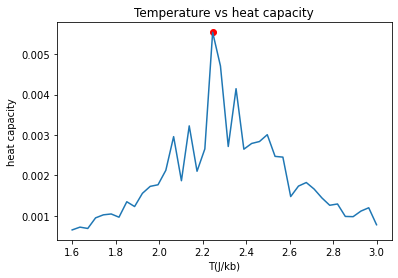

In [14]:
def cv(E,E2,T):
    return (E2-(E**2))/((T**2))
#define heat capacity function
import scipy.constants as constants
kb= constants.Boltzmann
cv2= np.vectorize(cv)
T=np.linspace(3,1.6,40)
y = cv2(aveng,avengsquared,T)
#y values of vectorised heat capacity
plt.plot(T, y, '-')
max=np.where(y == np.amax(y))
print(T[max])
plt.scatter(T[max],np.amax(y),marker='o',color='red')
#prints the temperature where max heat capacity occurs and labels it with a colored scatterpoint
plt.xlabel('T(J/kb)')
plt.ylabel('heat capacity')
plt.title('Temperature vs heat capacity')
plt.show()